The following resources are what I primarily used for this notebook. 

[Description of the MFCC Methodology](https://link.springer.com/content/pdf/bbm:978-3-319-49220-9/1.pdf)

[Descpription of applying the z-tranform in code](https://www.youtube.com/watch?v=nkq4WkX7CFU&t=1014s)

In this notebook, I will be exploring how to implement a basic pre-emphasis transfer function to a set of samples. For MFCC feature extraction, the most commonly used pre-emphasis filter is given by the following transfer function

$$
H(z) = 1 - bz^{-1}
$$
$$
b = [0.4, 1.0]
$$
The variable *b* controls the slope of the filter and is typically between 0.4 and 1.0. 

The inverse z-transform can be described as a linear equation of unit timesteps. Thus for the equation above, we would have the following equation in the time domain

$$
y(t) = x(t) - bx(t - 1)
$$

where y(t) is our sample after we've applied the z-transform and x(t) is a sample. 


In [46]:
# imports 
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
import control.matlab
from scipy.io import wavfile
from IPython.display import Audio


Below I am going to discretize the following Laplace Transform
$$
\frac{Y(s)}{U(s)} = H(s) = \frac{s + 2}{s^2 + s + 2}
$$

The transfer function, H(s)

   s + 2
-----------
s^2 + s + 2

The transfer function H(z) at Ts = 0.01

0.005025 z^2 + 9.95e-05 z - 0.004925
------------------------------------
       z^2 - 1.99 z + 0.9901

dt = 0.01

The transfer function H(z) at Ts = 1

0.5 z^2 + 0.5 z + 2.776e-17
---------------------------
     z^2 - 0.5 z + 0.5

dt = 1



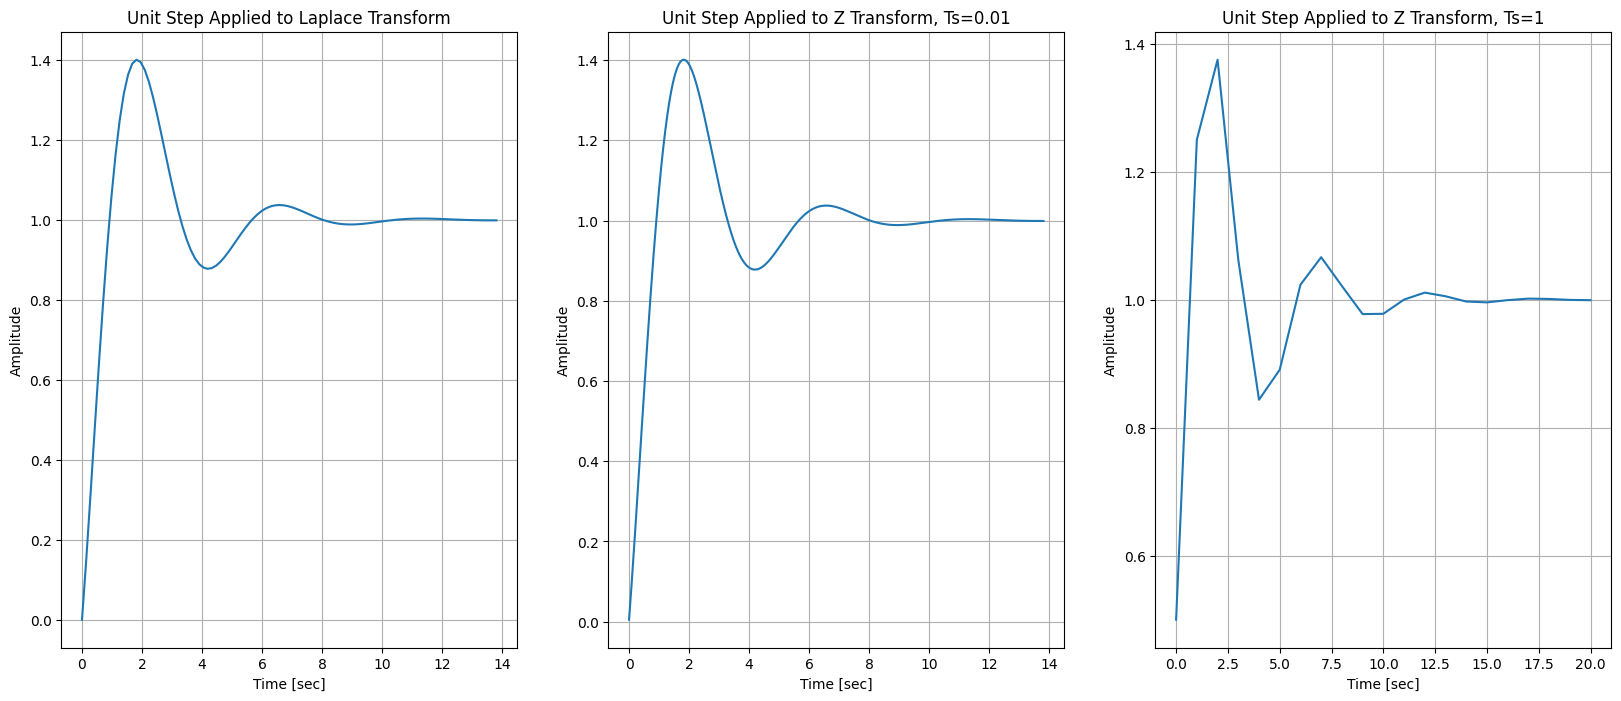

In [47]:
num = [1, 2] # numerators in transfer function
den = [1, 1, 2] # denominators in transfer function

Ts_1 = 0.01
Ts_2 = 1

lti = control.matlab.tf(num, den) # creating the transfer function
z_transform = control.matlab.c2d(lti, Ts_1, method='tustin', prewarp_frequency=None)
z_transform_2 = control.matlab.c2d(lti, Ts_2, method='tustin', prewarp_frequency=None)

print("The transfer function, H(s)")
print(lti)
print("The transfer function H(z) at Ts = {}".format(Ts_1))
print(z_transform)
print("The transfer function H(z) at Ts = {}".format(Ts_2))
print(z_transform_2)

y, tout = control.matlab.step(lti)
y_2, tout_2 = control.matlab.step(z_transform)
y_3, tout_3 = control.matlab.step(z_transform_2)

plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.plot(tout, y)
plt.title("Unit Step Applied to Laplace Transform")
plt.ylabel("Amplitude")
plt.xlabel("Time [sec]")
plt.grid(True)
plt.subplot(132)
plt.plot(tout_2, y_2)
plt.title("Unit Step Applied to Z Transform, Ts={}".format(Ts_1))
plt.ylabel("Amplitude")
plt.xlabel("Time [sec]")
plt.grid(True)
plt.subplot(133)
plt.plot(tout_3, y_3)
plt.title("Unit Step Applied to Z Transform, Ts={}".format(Ts_2))
plt.ylabel("Amplitude")
plt.xlabel("Time [sec]")
plt.grid(True)

As you can see above, as the period between samples becomes greater, the z-transform becomes less accurate to its continous counter part. In the scope of this project, the period between samples will correspond with the sampling rate of each wav file. Since the sampling rate of each wav file should generally be 44.1 kHz, the period between each sample should be relatively short, thus the z-transform should be a good approximate of the Laplace transform for these discretized samples. I chose to be lazy and use the Matlab Step function to apply the unit step to the z-transforms. In practice, the unit step would be discretized at a sampling rate corresponding to Ts, and the equation for the z-transform with a Ts of 0.01 seconds to implement in the time domain would be 
$$
y(t) = 0.005*u(t) + 9.95e-5*u(t-1) - 0.005*u(t-2) + 1.99*y(t-1) - 0.9901*y(t-2)
$$

Where $y(t-2)$ and $y(t-1)$ would need initial conditions. Below is a function implementing that implements the pre-emphasis filter in the time domain.

In [48]:
def pre_emphasis_filter(data, b = 0.4):
    prev_sample = 0
    output = np.zeros(len(data))

    for i in range(len(data)):
        output[i] = data[i] - b*prev_sample
        prev_sample = data[i]

    return output
        

In [49]:
wav_path = "music_samples_wav/chicago.wav"
# use Scipy's wav file reader
fs, scipy_samples = wavfile.read(wav_path)

Audio(scipy_samples, rate=fs)

/home/jchavez/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


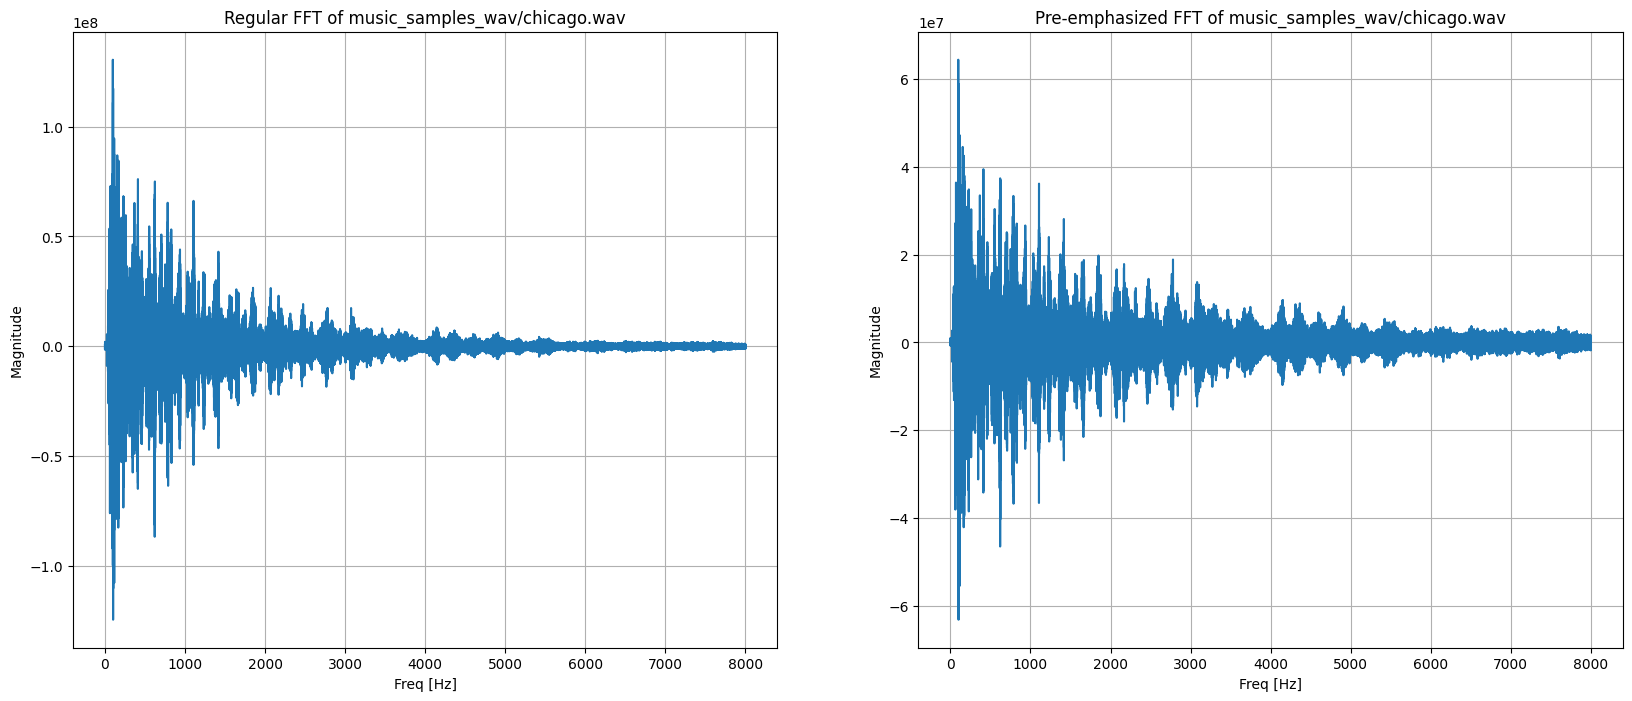

In [50]:
fft_results = np.fft.rfft(scipy_samples)
pre_samples = pre_emphasis_filter(scipy_samples, b = 0.5)
pre_fft_results = np.fft.rfft(pre_samples)

f = np.linspace(0, fs/2, len(fft_results))

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(f, fft_results)
plt.title("Regular FFT of {}".format(wav_path))
plt.ylabel("Magnitude")
plt.xlabel("Freq [Hz]")
plt.grid(True)
plt.subplot(122)
plt.plot(f, pre_fft_results)
plt.title("Pre-emphasized FFT of {}".format(wav_path))
plt.ylabel("Magnitude")
plt.xlabel("Freq [Hz]")
plt.grid(True)